In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_curve, classification_report

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import col, to_date, count, min, max, lit
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql.functions import col, sum as spark_sum, when
from pyspark.sql import SparkSession

print('Done importing libraries')

Done importing libraries


In [2]:
spark = SparkSession \
        .builder \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/27 13:36:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/airflow/.local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

# setup config

In [4]:
def setup_config():
    model_train_date_str = "2024-09-01"
    train_test_period_months = 12
    oot_period_months = 2
    train_test_ratio = 0.8

    config = {}
    config["model_train_date_str"] = model_train_date_str
    config["train_test_period_months"] = train_test_period_months
    config["oot_period_months"] =  oot_period_months
    config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d").date()
    config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
    config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
    config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
    config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
    config["train_test_ratio"] = train_test_ratio 

    print('Config:')
    pprint.pprint(config)

    return config

# setup config
config = setup_config()

Config:
{'model_train_date': datetime.date(2024, 9, 1),
 'model_train_date_str': '2024-09-01',
 'oot_end_date': datetime.date(2024, 8, 31),
 'oot_period_months': 2,
 'oot_start_date': datetime.date(2024, 7, 1),
 'train_test_end_date': datetime.date(2024, 6, 30),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.date(2023, 7, 1)}


# read feature and label store

In [5]:
def read_gold_table(table, gold_db, spark):
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df

In [6]:
X_spark = read_gold_table('feature_store', 'datamart/gold', spark)
y_spark = read_gold_table('label_store', 'datamart/gold', spark)

X_df = X_spark.toPandas().sort_values(by='customer_id')
y_df = y_spark.toPandas().sort_values(by='customer_id')
print('X_df shape:', X_df.shape)
print('y_df shape:', y_df.shape)

X_df shape: (8974, 74)
y_df shape: (8974, 5)


# modelling

In [7]:
# Consider data from model training date
y_model_df = y_df[(y_df['snapshot_date'] >= config['train_test_start_date']) & (y_df['snapshot_date'] <= config['model_train_date'])]
X_model_df = X_df[np.isin(X_df['customer_id'], y_model_df['customer_id'].unique())]

In [8]:
# split data into train - test - oot
y_oot = y_model_df[(y_model_df['snapshot_date'] >= config['oot_start_date']) & (y_model_df['snapshot_date'] <= config['oot_end_date'])]
X_oot = X_model_df[np.isin(X_model_df['customer_id'], y_oot['customer_id'].unique())]


y_traintest = y_model_df[y_model_df['snapshot_date'] <= config['train_test_end_date']]
X_traintest = X_model_df[np.isin(X_model_df['customer_id'], y_traintest['customer_id'].unique())]

X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, 
                                                test_size=1-config['train_test_ratio'], 
                                                random_state=1, 
                                                shuffle=True, 
                                                stratify=y_traintest['label']
                                            )

print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0])
print('y_test', y_test.shape[0])
print('y_oot', y_oot.shape[0])

X_train 4766
X_test 1192
X_oot 1003
y_train 4766
y_test 1192
y_oot 1003


# data preprocess

In [9]:
X_train_arr = X_train.drop(columns=['customer_id', 'snapshot_date']).values
X_test_arr = X_test.drop(columns=['customer_id', 'snapshot_date']).values
X_oot_arr = X_oot.drop(columns=['customer_id', 'snapshot_date']).values

y_train_arr = y_train['label'].values
y_test_arr = y_test['label'].values
y_oot_arr = y_oot['label'].values

In [10]:
# Standardize
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(X_train_arr)

X_train_arr = transformer_stdscaler.transform(X_train_arr)
X_test_arr = transformer_stdscaler.transform(X_test_arr)
X_oot_arr = transformer_stdscaler.transform(X_oot_arr)
print('X_train_arr', X_train_arr)
print('X_test_arr', X_test_arr)
print('X_oot_arr', X_oot_arr)

X_train_arr [[ 2.11040415 -0.07865732  0.60161609 ...  0.06151246  0.83938425
  -0.78431141]
 [-1.5883301  -0.12424543 -1.16454527 ...  0.63382345  0.74037004
  -1.27682888]
 [-1.1141334  -0.12417317 -1.12749304 ...  0.99871972 -0.13171664
  -0.69543608]
 ...
 [ 0.49813537 -0.12279916 -1.01754528 ... -1.5041806  -0.08839793
  -0.05016413]
 [ 1.44652877 -0.03803541  2.09188832 ...  0.22667604 -0.87622733
  -0.2214343 ]
 [ 0.21361736 -0.10287608 -0.28645055 ... -0.60874437  0.68197704
  -0.67815477]]
X_test_arr [[-0.92445472 -0.08394359  0.38562211 ...  0.67886807  0.41424632
   1.80687585]
 [ 0.21361736 -0.07400967  0.86081137 ... -1.3241331  -0.18598405
  -0.35104416]
 [ 0.68781405 -0.05947024  1.30929669 ...  0.38991911 -0.52237847
   0.07790276]
 ...
 [-0.6399367  -0.09855546 -0.14889943 ... -0.40068948 -2.59310832
  -2.83214721]
 [-1.1141334  -0.09968491 -0.18640463 ... -0.08828706  0.31575141
   0.52474818]
 [ 0.78265339 -0.12095698 -1.05894993 ... -0.76430541  0.75941123
  -1.2175

# model training

In [11]:
xgb_model = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=1)    
    
# Define the hyperparameter space to search
param_dist = {
    'n_estimators': [25, 50],
    'max_depth': [2, 3],  # lower max_depth to simplify the model
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}


In [12]:
# Create a scorer based on AUC score
auc_scorer = make_scorer(roc_auc_score)

In [13]:
# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=3,  
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=1,
    n_jobs=-1   # Use all available cores
)

In [14]:
# Perform the random search
random_search.fit(X_train_arr, y_train_arr)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [15]:
# AUC
y_pred_proba_train = best_model.predict_proba(X_train_arr)[:, 1]
train_auc = roc_auc_score(y_train_arr, y_pred_proba_train)

y_pred_proba_test = best_model.predict_proba(X_test_arr)[:, 1]
test_auc = roc_auc_score(y_test_arr, y_pred_proba_test)

y_pred_proba_oot = best_model.predict_proba(X_oot_arr)[:, 1]
oot_auc = roc_auc_score(y_oot_arr, y_pred_proba_oot)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"OOT AUC: {oot_auc:.4f}")

Train AUC: 0.8748
Test AUC: 0.8527
OOT AUC: 0.8972


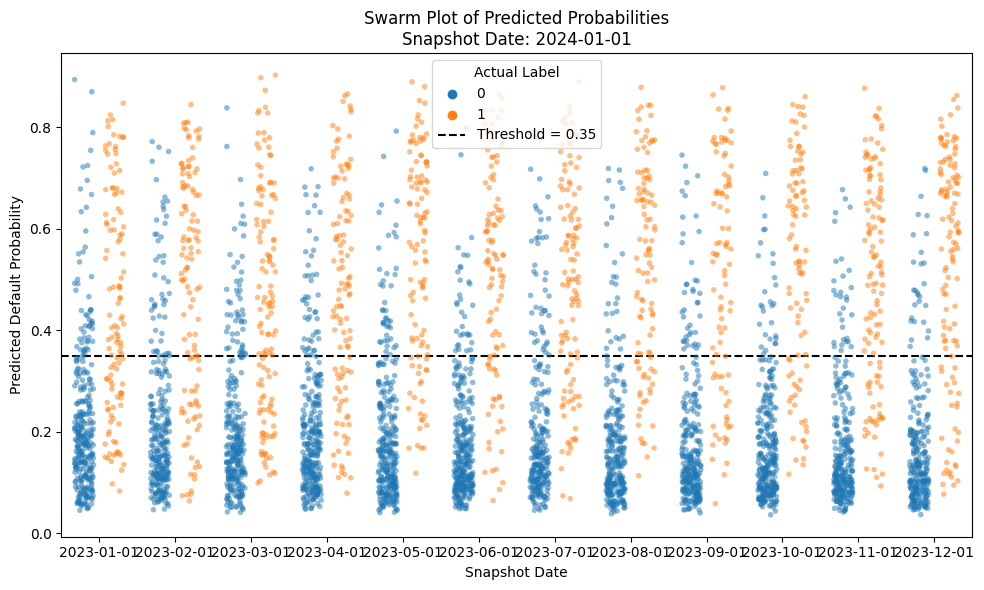

In [16]:
df_visualize = pd.DataFrame({
    'snapshot_date': X_train['snapshot_date'].values,
    'auc': y_pred_proba_train,
    'actual_label': y_train_arr
})
df_visualize = df_visualize.sort_values(by='snapshot_date')


plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df_visualize,
    x='snapshot_date',
    y='auc',
    hue='actual_label',
    dodge=True,
    jitter=0.25,
    alpha=0.5,
    size=4
)
# Draw threshold line (e.g. 0.35)
threshold = 0.35
plt.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')

# Annotate
plt.title('Swarm Plot of Predicted Probabilities\nSnapshot Date: 2024-01-01')
plt.ylabel('Predicted Default Probability')
plt.xlabel('Snapshot Date')
plt.legend(title='Actual Label')
plt.tight_layout()
plt.show()

In [17]:
# Accuracy
y_pred_train = best_model.predict(X_train_arr)
train_accuracy = accuracy_score(y_train_arr, y_pred_train)

y_pred_test = best_model.predict(X_test_arr)
test_accuracy = accuracy_score(y_test_arr, y_pred_test)

y_pred_oot = best_model.predict(X_oot_arr)
oot_accuracy = accuracy_score(y_oot_arr, y_pred_oot)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"OOT Accuracy: {oot_accuracy:.4f}")

Train Accuracy: 0.8296
Test Accuracy: 0.8188
OOT Accuracy: 0.8275


In [18]:
# Precision
train_precision = precision_score(y_train_arr, y_pred_train)
test_precision = precision_score(y_test_arr, y_pred_test)
oot_precision = precision_score(y_oot_arr, y_pred_oot)

print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"OOT Precision: {oot_precision:.4f}")

Train Precision: 0.8048
Test Precision: 0.7895
OOT Precision: 0.8352


In [19]:
# Recall
train_recall = recall_score(y_train_arr, y_pred_train)
test_recall = recall_score(y_test_arr, y_pred_test)
oot_recall = recall_score(y_oot_arr, y_pred_oot)
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"OOT Recall: {oot_recall:.4f}")

Train Recall: 0.5256
Test Recall: 0.4896
OOT Recall: 0.5052


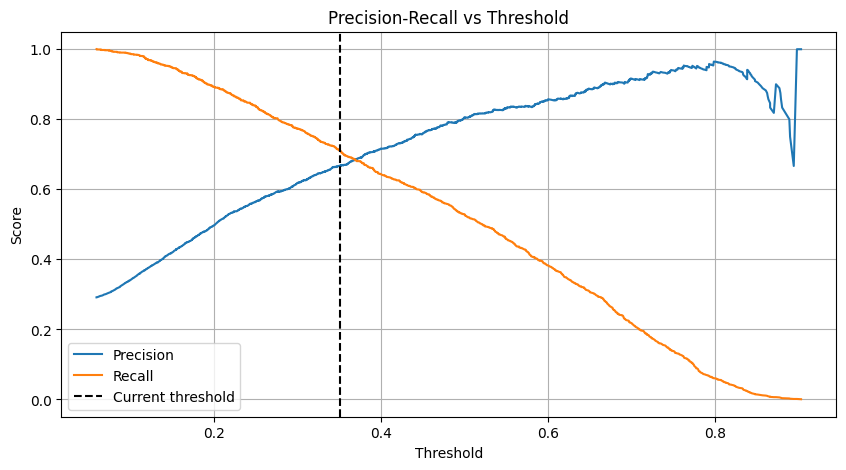

In [20]:
precision, recall, thresholds = precision_recall_curve(y_train_arr, y_pred_proba_train)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=0.35, linestyle='--', color='black', label='Current threshold')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [21]:
# F1 Score
train_f1 = f1_score(y_train_arr, y_pred_train)
test_f1 = f1_score(y_test_arr, y_pred_test)
oot_f1 = f1_score(y_oot_arr, y_pred_oot)

print(f"Train F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"OOT F1 Score: {oot_f1:.4f}")

Train F1 Score: 0.6359
Test F1 Score: 0.6044
OOT F1 Score: 0.6296


In [22]:
# classification report
train_cr = classification_report(y_train_arr, y_pred_train)
test_cr = classification_report(y_test_arr, y_pred_test)
oot_cr = classification_report(y_oot_arr, y_pred_oot)

print(f"Train report:\n {train_cr}")
print(f"Test report:\n {test_cr}")
print(f"OOT report:\n {oot_cr}")

Train report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      3417
           1       0.80      0.53      0.64      1349

    accuracy                           0.83      4766
   macro avg       0.82      0.74      0.76      4766
weighted avg       0.83      0.83      0.82      4766

Test report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88       855
           1       0.79      0.49      0.60       337

    accuracy                           0.82      1192
   macro avg       0.81      0.72      0.74      1192
weighted avg       0.81      0.82      0.80      1192

OOT report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       712
           1       0.84      0.51      0.63       291

    accuracy                           0.83      1003
   macro avg       0.83      0.73      0.76      1003
weighted avg       0.83      0.8

# save to model artefact

In [23]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "credit_model_"+config["model_train_date_str"].replace('-','_')

model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler

model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)


model_artefact['results'] = {}
model_artefact['results']['train_auc'] = train_auc
model_artefact['results']['test_auc'] = test_auc
model_artefact['results']['oot_auc'] = oot_auc
model_artefact['results']['train_f1'] = train_f1
model_artefact['results']['test_f1'] = test_f1
model_artefact['results']['oot_f1'] = oot_f1
model_artefact['results']['train_accuracy'] = train_accuracy
model_artefact['results']['test_accuracy'] = test_accuracy
model_artefact['results']['oot_accuracy'] = oot_accuracy
model_artefact['results']['train_precision'] = train_precision
model_artefact['results']['test_precision'] = test_precision
model_artefact['results']['oot_precision'] = oot_precision
model_artefact['results']['train_recall'] = train_recall
model_artefact['results']['test_recall'] = test_recall
model_artefact['results']['oot_recall'] = oot_recall


model_artefact['hp_params'] = random_search.best_params_

pprint.pprint(model_artefact)

{'data_dates': {'model_train_date': datetime.date(2024, 9, 1),
                'model_train_date_str': '2024-09-01',
                'oot_end_date': datetime.date(2024, 8, 31),
                'oot_period_months': 2,
                'oot_start_date': datetime.date(2024, 7, 1),
                'train_test_end_date': datetime.date(2024, 6, 30),
                'train_test_period_months': 12,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.date(2023, 7, 1)},
 'data_stats': {'X_oot': 1003,
                'X_test': 1192,
                'X_train': 4766,
                'y_oot': label    0.29
dtype: float64,
                'y_test': label    0.28
dtype: float64,
                'y_train': label    0.28
dtype: float64},
 'hp_params': {'colsample_bytree': 0.6,
               'gamma': 0,
               'learning_rate': 0.1,
               'max_depth': 2,
               'min_child_weight': 1,
               'n_estimators': 50,
               'reg_alph

/home/airflow/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/home/airflow/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app
/home/airflow/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


# save model

In [24]:
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")

Model saved to model_bank/credit_model_2024_09_01.pkl
